In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
tables = ['measurement', 'station']
print(tables)

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


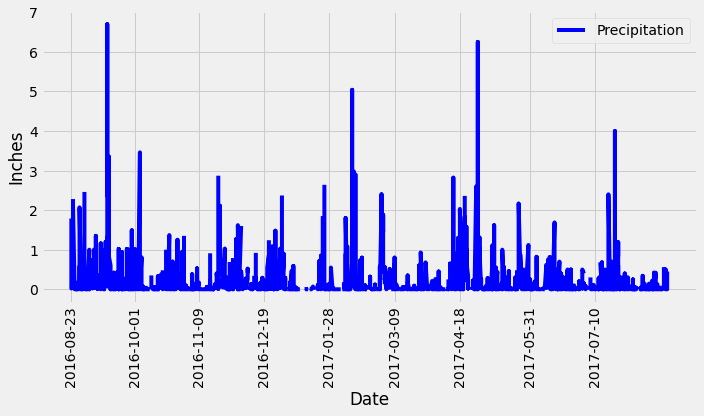

In [10]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()

one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d') 

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all() 

precipitation_data = pd.DataFrame(results, columns=['date', 'precipitation']) 

precipitation_data['date'] = pd.to_datetime(precipitation_data['date']) 

precipitation_data = precipitation_data.sort_values('date') 

date = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10'] 


plt.figure(figsize=(10, 6)) 

plt.plot(precipitation_data['date'], precipitation_data['precipitation'], linestyle='-', markersize=8, color='blue', label='Precipitation') 


plt.xlabel('Date') 
plt.ylabel('Inches') 
plt.xticks(pd.to_datetime(date), date, rotation=90) 

plt.grid(True) 
plt.legend(loc='upper right') 

plt.tight_layout() 
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_data['precipitation'].describe()
print("precipitation")
print(summary_stats)

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print([(total_stations,)])

[(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print({station}, {count})

{'USC00519281'} {2772}
{'USC00519397'} {2724}
{'USC00513117'} {2709}
{'USC00519523'} {2669}
{'USC00516128'} {2612}
{'USC00514830'} {2202}
{'USC00511918'} {1979}
{'USC00517948'} {1372}
{'USC00518838'} {511}


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query( 
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs) 
).filter(Measurement.station == most_active_station_id).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print([(lowest_temp, highest_temp, avg_temp)])

[(54.0, 85.0, 71.66378066378067)]


[{'date': '2016-08-23', 'tobs': 77.0}, {'date': '2016-08-24', 'tobs': 77.0}, {'date': '2016-08-25', 'tobs': 80.0}, {'date': '2016-08-26', 'tobs': 80.0}, {'date': '2016-08-27', 'tobs': 75.0}]


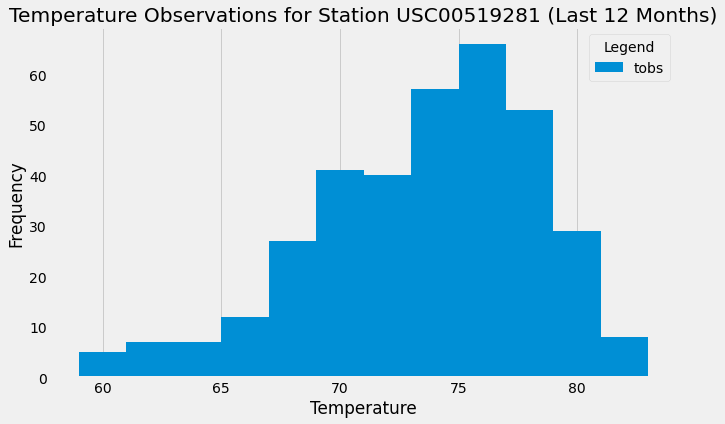

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'

most_recent_date = session.query(func.max(Measurement.date)).scalar() 
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

results = session.query(Measurement.date, Measurement.tobs).filter( 
    Measurement.station == most_active_station_id, 
    Measurement.date >= one_year_ago 
).all()

temperature_data = [{'date': date, 'tobs': tobs} for date, tobs in results]

print(temperature_data[:5])

temperature_df = pd.DataFrame(temperature_data)

plt.figure(figsize=(10, 6)) 
n, bins, patches = plt.hist(temperature_df['tobs'], bins=12) 
patches[0].set_label('tobs')

plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)') 
plt.xlabel('Temperature') 
plt.ylabel('Frequency') 
plt.grid(axis='y')
plt.legend(title='Legend')

plt.show()

# Close Session

In [27]:
# Close Session
session.close()